In [1]:
import os.path
import cv2
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import src.metrics as nc_metrics
import src.utils as nc_utils
import notebooks.sandbox.models as nc_models

from pathlib import Path
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import models

from tensorflow.keras.metrics import Recall, Precision

2024-02-16 21:31:23.221252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 21:31:23.221299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 21:31:23.223062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 21:31:23.233831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 21:31:24.537261: W tensorflow/compiler/tf2

In [2]:
strategy = nc_utils.start_session()

ROOT_DIR = "."
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
MASK_DIR = os.path.join(ROOT_DIR, "masks")

BATCH_SIZE = 4
LR = 1e-4  # Learning rate
EPOCHS = 300

smallest_dimension = nc_utils.get_smallest_image_dimension(IMAGE_DIR)

#IMAGE_SIZE = smallest_dimension
IMAGE_SIZE = 256
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

2024-02-16 21:31:26.045025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-16 21:31:26.099855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-16 21:31:26.100247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
(x_train_paths, y_train_paths), (x_valid_paths, y_valid_paths), (
x_test_paths,
y_test_paths) = nc_utils.load_data(
    image_directory=IMAGE_DIR,
    mask_directory=MASK_DIR,
    split=0.1
)

train_dataset = nc_utils.get_tensorflow_dataset(
    image_mask_paths=(x_train_paths, y_train_paths),
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = nc_utils.get_tensorflow_dataset(
    image_mask_paths=(x_valid_paths, y_valid_paths),
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_dataset = nc_utils.get_tensorflow_dataset(
    image_mask_paths=(x_test_paths, y_test_paths),
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

data_aug = nc_utils.get_data_augmentation_pipeline()

In [4]:
# Initiating model on GPU
with strategy.scope():
    model = nc_models.unet_model(input_shape=INPUT_SHAPE, augment_data=True)
    metrics=[nc_metrics.continuous_dice_coefficient, nc_metrics.dice_coefficient]
    loss=nc_metrics.cdc_loss
    opt=tf.keras.optimizers.Nadam(LR)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         448       ['sequential_1[0][0]']        
                                                                                                  
 batch_normalization_1 (Bat  (None, 256, 256, 16)         64        ['conv2d_1[0][0]']            
 chNormalization)                                                                             

In [6]:
# Compiling model
model.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         restore_best_weights=True)
reduce_learning = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.1,
                                              patience=4)

In [7]:
train_steps = len(x_train_paths) // BATCH_SIZE
valid_steps = len(x_valid_paths) // BATCH_SIZE

if len(x_train_paths) % BATCH_SIZE != 0:
    train_steps += 1
if len(x_valid_paths) % BATCH_SIZE != 0:
    valid_steps += 1

try:
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=validation_dataset,
        callbacks=[early_stopping, reduce_learning],
        steps_per_epoch=train_steps,
        validation_steps=valid_steps)
except Exception as e:
    print("An error occurred:", e)

Epoch 1/300


2024-02-16 21:31:34.249912: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-16 21:31:34.377311: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-16 21:31:34.418790: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-16 21:31:37.642552: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-16 21:31:38.071549: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

66/66 [==============================] - 82s 759ms/step - loss: 0.9445 - continuous_dice_coefficient: 0.0555 - dice_coefficient: 0.0554 - val_loss: 0.9604 - val_continuous_dice_coefficient: 0.0366 - val_dice_coefficient: 0.0358 - lr: 1.0000e-04
Epoch 2/300
66/66 [==============================] - 46s 697ms/step - loss: 0.9296 - continuous_dice_coefficient: 0.0704 - dice_coefficient: 0.0702 - val_loss: 0.9416 - val_continuous_dice_coefficient: 0.0541 - val_dice_coefficient: 0.0532 - lr: 1.0000e-04
Epoch 3/300
66/66 [==============================] - 46s 698ms/step - loss: 0.9230 - continuous_dice_coefficient: 0.0770 - dice_coefficient: 0.0767 - val_loss: 0.9296 - val_continuous_dice_coefficient: 0.0651 - val_dice_coefficient: 0.0649 - lr: 1.0000e-04
Epoch 4/300
66/66 [==============================] - 47s 710ms/step - loss: 0.9184 - continuous_dice_coefficient: 0.0816 - dice_coefficient: 0.0813 - val_loss: 0.9242 - val_continuous_dice_coefficient: 0.0700 - val_dice_coefficient: 0.0700 -

In [8]:
test_steps = len(x_test_paths) // BATCH_SIZE
if len(x_test_paths) % BATCH_SIZE != 0:
    test_steps += 1
    
model.evaluate(test_dataset, steps=test_steps)

9/9 [==============================] - 2s 235ms/step - loss: 0.3210 - continuous_dice_coefficient: 0.6228 - dice_coefficient: 0.4328


[0.3210420310497284, 0.6228256821632385, 0.43284791707992554]

# Results

In [9]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [10]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 0s 101ms/step


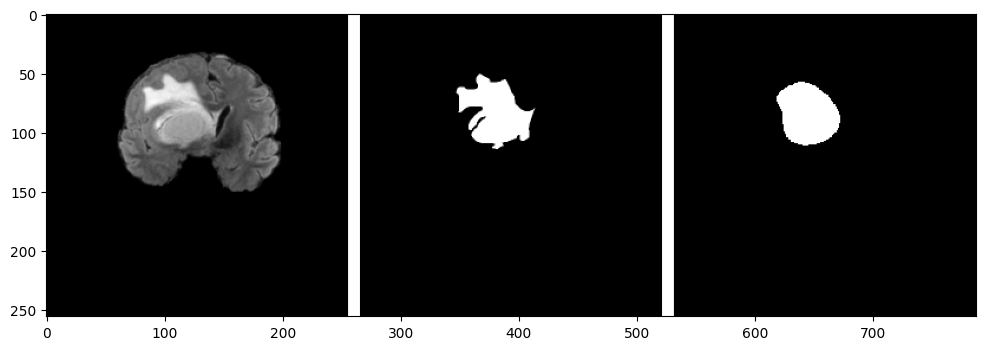

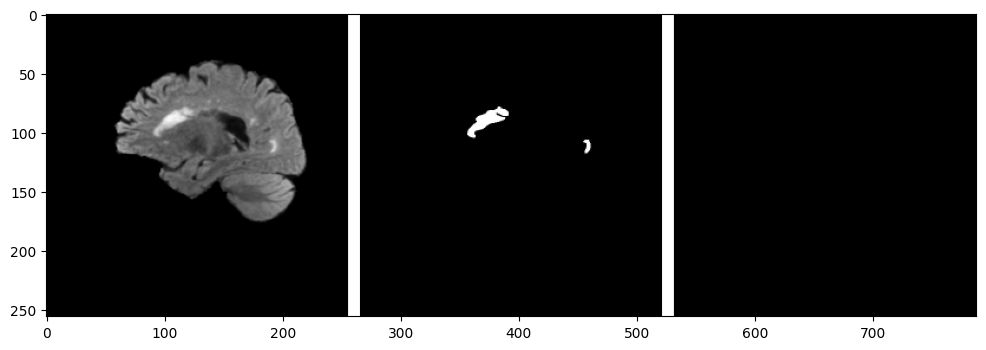

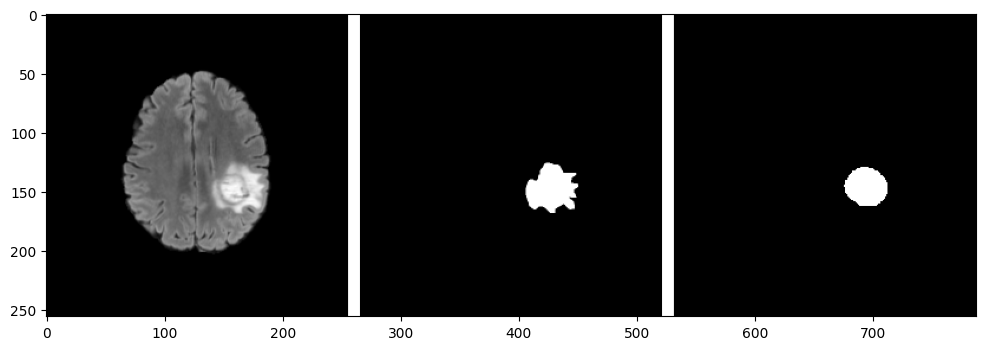

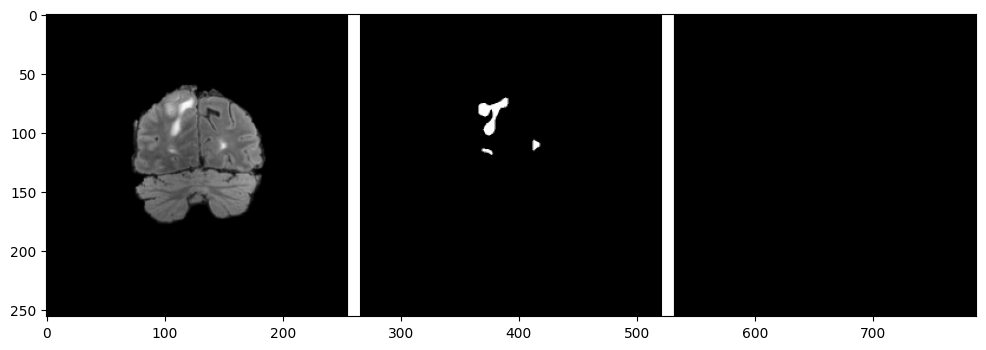

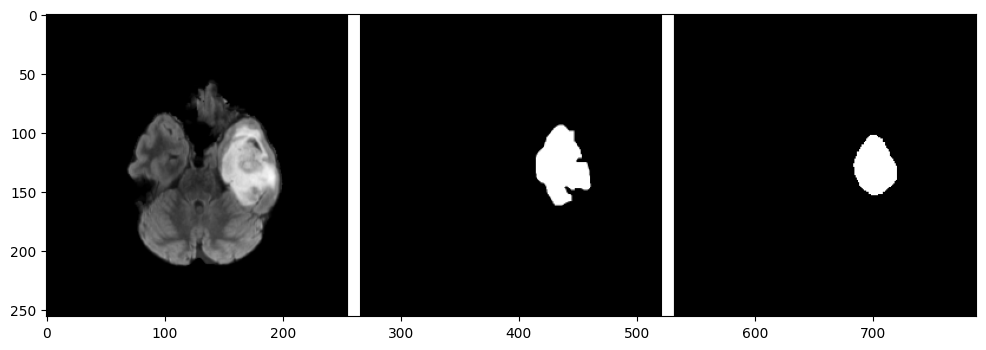

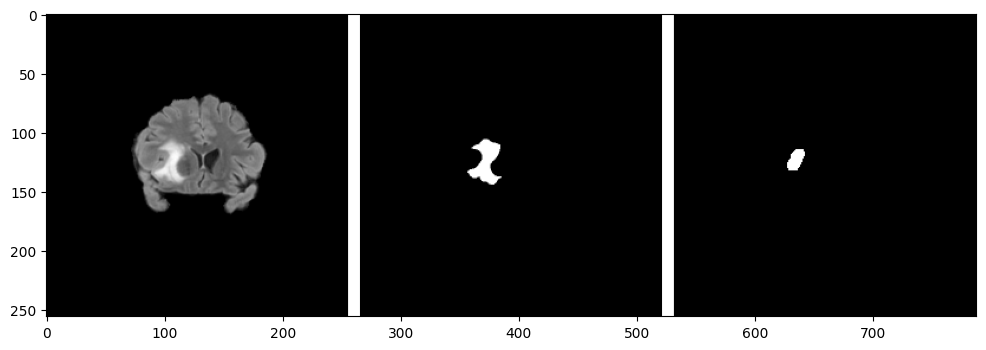

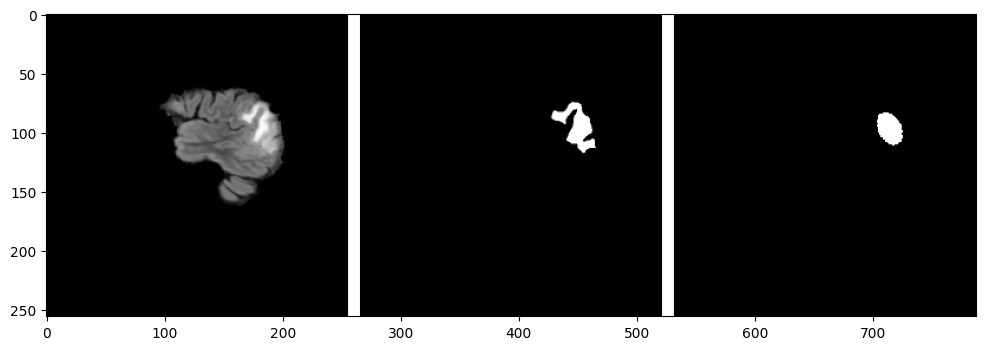

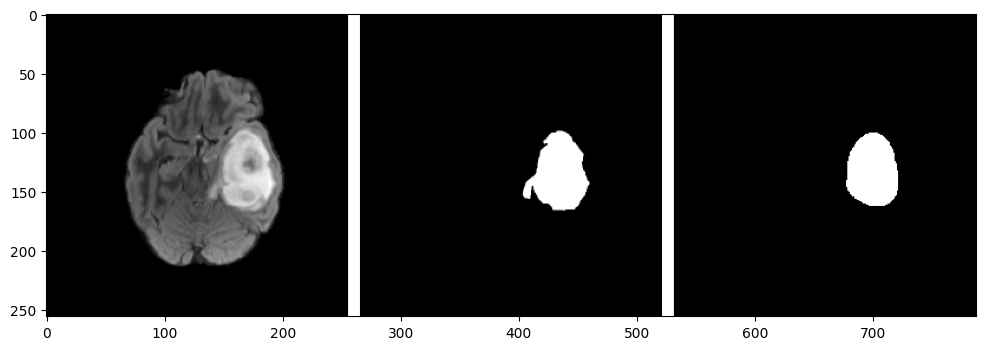

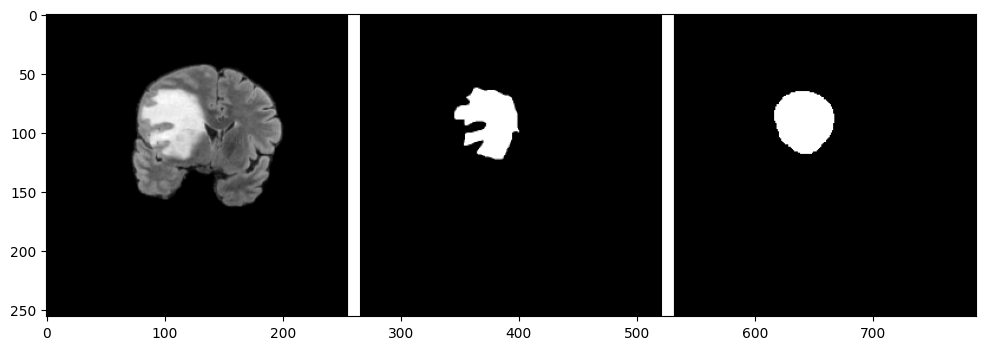

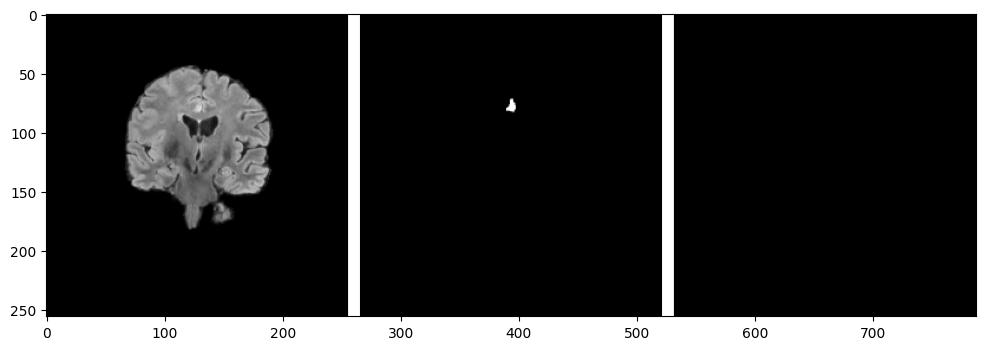

In [11]:
for i, (x, y) in enumerate(zip(x_test_paths[:10], y_test_paths[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)